Building a model that predicts whether a pokemon is legendary based on image data, without using generators.

In [39]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

### Preparing the Dataset with Names and Labels

In [2]:
info1 = '../data/pokemon_cleaned.csv'
pkm1 = pd.read_csv(info1, index_col = 0)
pkm1 = pkm1.loc[:, ['name', 'is_legendary']]
pkm1['name'] = pkm1['name'].map(lambda x:x.lower())
pkm1.head()

,name,is_legendary
0,bulbasaur,0
1,ivysaur,0
2,venusaur,0
3,charmander,0
4,charmeleon,0


In [3]:
info2 = '../data/pokemon_types.csv'
pkm2 = pd.read_csv(info2)
pkm2 = pkm2[['Name']]
pkm2.rename({'Name':'name'}, axis = 1, inplace = True)
pkm2.head()

,name
0,bulbasaur
1,ivysaur
2,venusaur
3,charmander
4,charmeleon


In [8]:
pkm = pd.merge(pkm2, pkm1, how = 'left')
pkm.head()

,name,is_legendary
0,bulbasaur,0.0
1,ivysaur,0.0
2,venusaur,0.0
3,charmander,0.0
4,charmeleon,0.0


In [9]:
pkm['is_legendary'].unique()

array([ 0., nan,  1.])

In [10]:
pkm.loc[pkm['is_legendary'].isna(), :]

,name,is_legendary
28,nidoran-f,NaN
31,nidoran-m,NaN
82,farfetchd,NaN
121,mr-mime,NaN
385,deoxys-normal,NaN
412,wormadam-plant,NaN
438,mime-jr,NaN
486,giratina-altered,NaN
491,shaymin-land,NaN
549,basculin-red-striped,NaN


In [11]:
pkm.loc[pkm['is_legendary'].isna(), 'is_legendary'] = [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
                                                      0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
                                                      1, 1, 1, 1]

In [12]:
pkm['is_legendary'].unique()

array([0., 1.])

In [13]:
pkm['is_legendary'] = pkm['is_legendary'].astype(int)

In [58]:
pkm

,name,is_legendary
0,bulbasaur,0
1,ivysaur,0
2,venusaur,0
3,charmander,0
4,charmeleon,0
...,...,...
804,stakataka,1
805,blacephalon,1
806,zeraora,1
807,meltan,1


### Adding Vectorized Images to the Data Set

In [15]:
img_dir = '../data/images'

In [16]:
d = {}

for img in os.listdir(img_dir):
    if '.png' in img:
        pkm_name = img.replace('.png', '')
    elif '.jpg' in img:
        pkm_name = img.replace('.jpg', '')
    
    img_add = img_dir + '/' + img
    img = load_img(img_add, color_mode = 'rgba', target_size = (120, 120))
    
    img_vec = np.asarray(img).reshape(120*120*4).astype('float32') / 255
    
    d[pkm_name] = img_vec

pkm_img = pd.DataFrame(d)

In [20]:
pkm_img.T

,0,1,2,3,4,5,6,7,8,9,...,57590,57591,57592,57593,57594,57595,57596,57597,57598,57599
abomasnow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
absol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accelgor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aegislash-blade,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zoroark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zorua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zubat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zweilous,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
pkm_df = pd.merge(pkm, pkm_img.T, how = 'inner', left_on = 'name', right_index = True)

In [22]:
pkm_df.head()

,name,is_legendary,0,1,2,3,4,5,6,7,...,57590,57591,57592,57593,57594,57595,57596,57597,57598,57599
0,bulbasaur,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ivysaur,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,venusaur,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,charmander,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,charmeleon,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
print(pkm_df.isna().sum().sum())
print(pkm_df.shape)

0
(809, 57602)


In [25]:
pkm_images_data = pkm_df.drop('is_legendary', axis = 1).set_index('name')
pkm_images_data

,0,1,2,3,4,5,6,7,8,9,...,57590,57591,57592,57593,57594,57595,57596,57597,57598,57599
name,,,,,,,,,,,,,,,,,,,,,
bulbasaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ivysaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
venusaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charmander,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charmeleon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stakataka,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
blacephalon,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zeraora,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [26]:
pkm_labels = pkm_df.loc[:, ['name', 'is_legendary']].set_index('name')
pkm_labels

,is_legendary
name,
bulbasaur,0
ivysaur,0
venusaur,0
charmander,0
charmeleon,0
...,...
stakataka,1
blacephalon,1
zeraora,1


Build the training, validation and test set

In [27]:
trainX, remX, trainY, remY = train_test_split(pkm_images_data, pkm_labels, test_size = 0.4, 
                                              random_state = 1234, stratify = pkm_labels)

valX, testX, valY, testY = train_test_split(remX, remY, test_size = 0.5, 
                                              random_state = 1234, stratify = remY)

In [28]:
print(trainX.shape, valX.shape, testX.shape)

(485, 57600) (162, 57600) (162, 57600)


In [33]:
trainX = trainX.to_numpy().reshape(485, 120, 120, 4)
valX = valX.to_numpy().reshape(162, 120, 120, 4)
testX = testX.to_numpy().reshape(162, 120, 120, 4)

In [34]:
trainY.value_counts()

is_legendary
0               438
1                47
Name: count, dtype: int64

One-hot encode the labels:

In [36]:
trainY = to_categorical(trainY)
valY = to_categorical(valY)
testY = to_categorical(testY)

In [38]:
print(trainY.shape, valY.shape, testY.shape)

(485, 2) (162, 2) (162, 2)


### Model

In [40]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (120, 120, 4)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(300, activation = 'relu'))
model.add(layers.Dense(2, activation = 'softmax'))

model.summary()

model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       960,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           602 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,202,022 (4.59 MB)

 Trainable params: 1,202,022 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    mode = 'auto'
)

csv_logger = CSVLogger('../output/logs/leg_training_01.log',
                       separator = ',', 
                       append = False)

In [ ]:
history = model.fit(trainX,
                    trainY,
                    epochs = 60,
                    batch_size = 32,
                    validation_data = (valX, valY),
                    validation_batch_size = 32,
                    callbacks = [earlystop, csv_logger])

Epoch 1/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.7884 - loss: 0.5261 - val_accuracy: 0.9074 - val_loss: 0.5375
Epoch 2/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9089 - loss: 0.2871 - val_accuracy: 0.9074 - val_loss: 0.3703
Epoch 3/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.8949 - loss: 0.2938 - val_accuracy: 0.9074 - val_loss: 0.4755
Epoch 4/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9087 - loss: 0.2560 - val_accuracy: 0.9074 - val_loss: 0.3567
Epoch 5/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.9038 - loss: 0.2843 - val_accuracy: 0.9074 - val_loss: 0.4273
Epoch 6/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.8952 - loss: 0.2723 - val_accuracy: 0.9074 - val_loss: 0.4431
Epoch 7/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.9330 - loss: 0.1923 - val_accuracy: 0.9074 - val_loss: 0.3475
Epoch 8/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9065 - loss: 0.2054 - val_accuracy: 0.

Plotting Data

In [45]:
%matplotlib inline

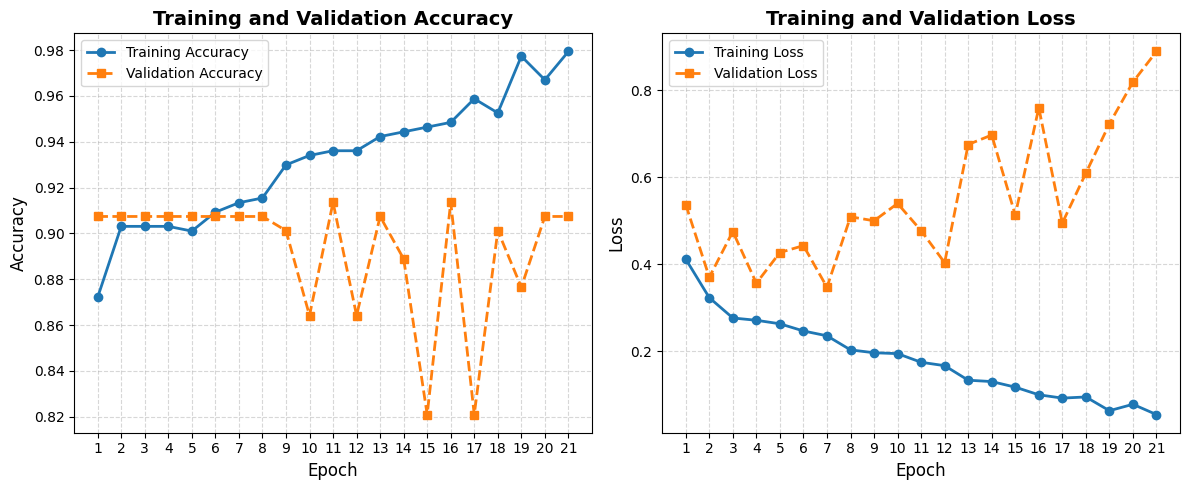

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color = 'tab:blue', label = 'Training Accuracy', linewidth = 2, markersize = 6)
plt.plot(epochs, val_acc, 's--', color = 'tab:orange', label = 'Validation Accuracy', linewidth = 2, markersize = 6)
plt.title('Training and Validation Accuracy', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color = 'tab:blue', label = 'Training Loss', linewidth = 2, markersize = 6)
plt.plot(epochs, val_loss, 's--', color = 'tab:orange', label = 'Validation Loss', linewidth = 2, markersize = 6)
plt.title('Training and Validation Loss', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.tight_layout()
plt.show()


Training on all data and test on Test Data

In [47]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (120, 120, 4)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(300, activation = 'relu'))
model.add(layers.Dense(2, activation = 'softmax'))

model.summary()

model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 118, 118, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │       960,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           602 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,202,022 (4.59 MB)

 Trainable params: 1,202,022 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history = model.fit(np.concatenate([trainX, valX]),
                    np.concatenate([trainY, valY]),
                    epochs = 30,
                    batch_size = 32)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.8033 - loss: 0.5134
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.9025 - loss: 0.3228
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.9161 - loss: 0.2743
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.9127 - loss: 0.2638
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.9042 - loss: 0.3505
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.9274 - loss: 0.2297
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.9072 - loss: 0.2734
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.9240 - loss: 0.2131
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.9087 - loss: 0.2337
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.9363 - loss: 0.1820
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9342 - loss: 0.1739
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step

In [53]:
models_folder = '../output/models'

In [54]:
model.save(models_folder + '/leg_CNN_01.keras')

In [59]:
test_loss, test_acc = model.evaluate(testX, testY)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8797 - loss: 1.0005


In [60]:
def cm_keras_generator(pred_generator):
    preds = model.predict(pred_generator)
    classes = list(pred_generator.class_indices.keys())
    pred_values = preds.argmax(axis = 1)
    preds_labels = np.array(classes)[pred_values]
    true_values = pred_generator.classes
    true_labels = np.array(classes)[true_values]
    res = pd.DataFrame({'true':true_labels, 'predicted':preds_labels})
    cm = confusion_matrix(true_values, pred_values)
    df_cm = pd.DataFrame(cm, 
                     index = [c for c in classes],
                     columns = [c for c in classes])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    
    return res, df_cm

In [61]:
model.predict(testX)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


array([[1.00000000e+00, 1.71628545e-09],
       [1.00000000e+00, 2.75272956e-29],
       [1.00000000e+00, 3.22736872e-11],
       [1.00000000e+00, 2.72708544e-18],
       [1.00000000e+00, 1.38968379e-20],
       [1.00000000e+00, 5.87909439e-18],
       [1.00000000e+00, 9.65668805e-15],
       [1.00000000e+00, 2.19851451e-28],
       [1.00000000e+00, 4.53359546e-25],
       [3.11774552e-01, 6.88225448e-01],
       [1.00000000e+00, 1.79315555e-11],
       [1.00000000e+00, 7.07405217e-13],
       [6.81237727e-02, 9.31876183e-01],
       [1.00000000e+00, 7.98496519e-15],
       [1.00000000e+00, 9.55928044e-20],
       [1.00000000e+00, 9.74996586e-15],
       [1.00000000e+00, 9.26643859e-29],
       [1.00000000e+00, 3.46718279e-17],
       [1.00000000e+00, 7.50244233e-22],
       [1.00000000e+00, 1.50209231e-14],
       [1.00000000e+00, 9.64610054e-19],
       [1.00000000e+00, 2.45932170e-18],
       [9.99950886e-01, 4.90791244e-05],
       [1.00000000e+00, 6.89000873e-31],
       [9.999054

In [62]:
preds = model.predict(testX)
pred_values = preds.argmax(axis = 1)
true_values = testY.argmax(axis = 1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [63]:
cm = confusion_matrix(true_values, pred_values)

df_cm = pd.DataFrame(cm, 
                    index = [c for c in ['not legendary', 'legendary']],
                    columns = [c for c in ['not legendary', 'legendary']])

<Axes: >

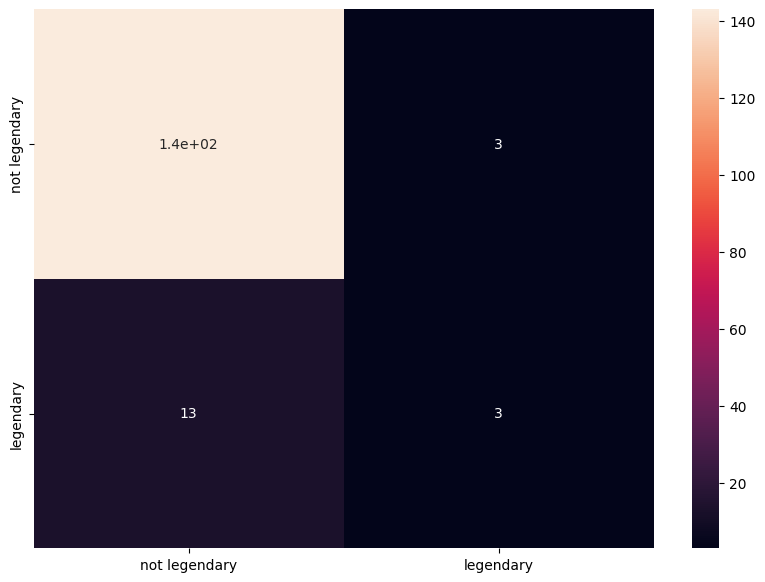

In [64]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)